https://catalog.data.gov/dataset/3-year-recidivism-for-offenders-released-from-prison

In [256]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing, neighbors, grid_search, cross_validation
from sklearn import model_selection


sns.set(style="whitegrid", color_codes=True)
np.random.seed(sum(map(ord, "categorical")))
%matplotlib inline
plt.style.use('ggplot')




In [257]:
# read in dataset
df = pd.read_csv('/Users/matanefron/Downloads/3-Year_Recidivism_for_Offenders_Released_from_Prison.csv')

In [258]:
#Set recidivism to true or false
df['Recidivism'] = df['Recidivism - Return to Prison']=='Yes'
#Change it to binary
df.Recidivism = df.Recidivism.astype(int)



In [259]:
df.head(1)

,Offender,Recidivism Reporting Year,Race - Ethnicity,Sex,Age At Release,Convicting Offense Classification,Convicting Offense Type,Convicting Offense Subtype,Release Type,Main Supervising District,Recidivism - Return to Prison,Recidivism Type,Days to Recidivism,New Conviction Offense Classification,New Conviction Offense Type,New Conviction Offense Sub Type,Part of Target Population,Recidivism
0,1,FY13,White - Non-Hispanic,M,Under 25,D Felony,Violent,Assault,Parole,4JD,Yes,Tech,16.0,NaN,NaN,NaN,Yes,1


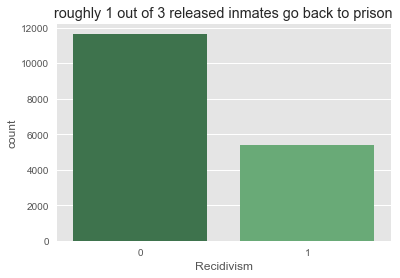

In [261]:
ax = plt.axes()
sns.countplot(x="Recidivism", data=df, palette="Greens_d")
ax.set_title('roughly 1 out of 3 released inmates go back to prison')
plt.show()


#1963

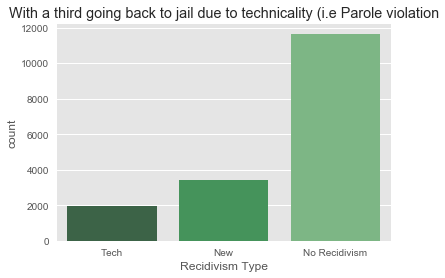

In [262]:
ax = plt.axes()
sns.countplot(x="Recidivism Type", data=df, palette="Greens_d")
ax.set_title('With a third going back to jail due to technicality (i.e Parole violation')
plt.show()


In [263]:
# Create two new tables with Recidivism Y and for ease of future calcs
df_rec_y = df[df['Recidivism']==1]
df_rec_n = df[df['Recidivism']==0]



In [264]:
# Recidivism by Race

print "Count Recidivism by Race"

print df.groupby('Race - Ethnicity')['Recidivism'].count()



Count Recidivism by Race
Race - Ethnicity
American Indian or Alaska Native - Hispanic           14
American Indian or Alaska Native - Non-Hispanic      318
Asian or Pacific Islander - Hispanic                   2
Asian or Pacific Islander - Non-Hispanic             126
Black -                                                2
Black - Hispanic                                      26
Black - Non-Hispanic                                4078
N/A -                                                  4
White -                                               11
White - Hispanic                                    1030
White - Non-Hispanic                               11419
Name: Recidivism, dtype: int64


In [265]:
#Reduce race categories

def classify_race(x):
    if x == 'White - ' or x=='White - Non-Hispanic':
        return 'white'
    elif x == 'Black - ' or x=='Black - Non-Hispanic' :
        return 'black'
    elif x == 'N/A -' or x=='American Indian or Alaska Native - Non-Hispanic':
        return 'other'
    elif x == 'Asian or Pacific Islander - Non-Hispanic':
        return 'other'
    else:
        return 'Hispanic'



In [266]:
#Map back 
df['Race'] = df['Race - Ethnicity'].map(classify_race)

df_rec_y['Race'] = df_rec_y['Race - Ethnicity'].map(classify_race)
df_rec_n['Race'] = df_rec_n['Race - Ethnicity'].map(classify_race)

/Users/matanefron/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/matanefron/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Axes(0.125,0.125;0.775x0.755)
% Recidivism by Gender
Sex
F    27.0%
M    32.0%
Name: Recidivism, dtype: object


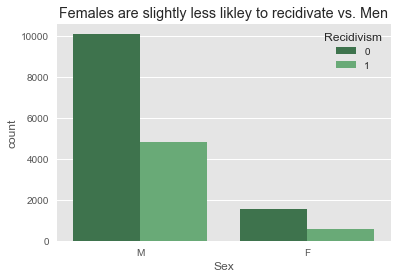

In [267]:
ax = plt.axes()
print sns.countplot(x="Sex",hue="Recidivism", data=df, palette="Greens_d");
ax.set_title('Females are slightly less likley to recidivate vs. Men')


print "% Recidivism by Gender" 
print np.round(100*pd.to_numeric(df_rec_y.groupby('Sex')['Recidivism'].count(),errors='coerce')/
df.groupby('Sex')['Recidivism'].count()).astype(str) + "%"

plt.show()
 

% Recidivism by Race
Race
Hispanic    19.0%
black       33.0%
other       34.0%
white       32.0%
Name: Recidivism, dtype: object


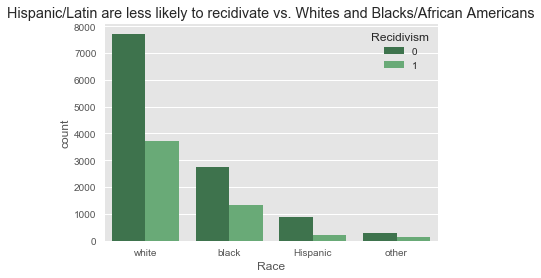

In [268]:
ax = plt.axes()
sns.countplot(x="Race",hue="Recidivism",order =('white','black','Hispanic','other'),data=df, palette="Greens_d");
ax.set_title('Hispanic/Latin are less likely to recidivate vs. Whites and Blacks/African Americans')

print "% Recidivism by Race" 
print np.round(100*(pd.to_numeric(df_rec_y.groupby('Race')['Recidivism'].count(),errors='coerce')
           /df.groupby('Race')['Recidivism'].count())).astype(str) + '%'
plt.show()


% Recidivism by Age of Release
Convicting Offense Type
Drug            34.0%
Other           43.0%
Property        35.0%
Public Order    28.0%
Violent         25.0%
Name: Recidivism, dtype: object


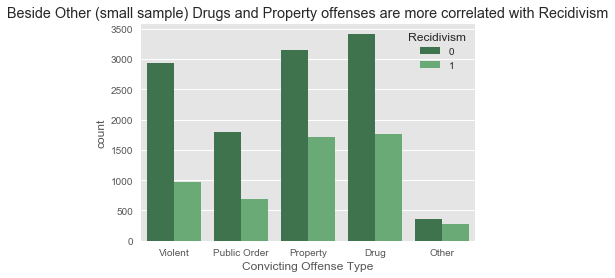

In [271]:
ax = plt.axes()
sns.countplot(x="Convicting Offense Type",hue="Recidivism", data=df, palette="Greens_d");

ax.set_title('Beside Other (small sample) Drugs and Property offenses are more correlated with Recidivism')

print "% Recidivism by Age of Release" 
print np.round(100*pd.to_numeric(df_rec_y.groupby('Convicting Offense Type')['Recidivism'].count(),errors='coerce')
                    /df.groupby('Convicting Offense Type')['Recidivism'].count()).astype(str)+ "%"


plt.show()

Recidivism by Gender X Offense Type


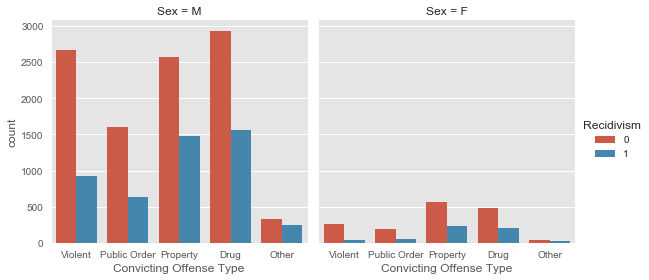

In [274]:
print "Recidivism by Gender X Offense Type"

sns.factorplot(
    col= 'Sex',
    x = 'Convicting Offense Type',
    hue = 'Recidivism',
    data=df,
    kind='count',
)

plt.show()



% Recidivism by Age of Release
Age At Release 
25-34           33.0%
35-44           31.0%
45-54           27.0%
55 and Older    19.0%
Under 25        37.0%
Name: Recidivism, dtype: object


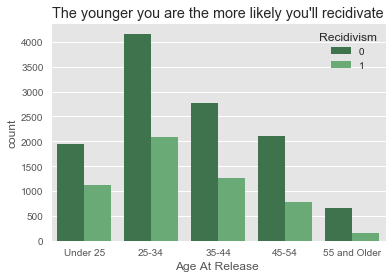

In [269]:
ax = plt.axes()
sns.countplot(x="Age At Release ",hue="Recidivism",order=('Under 25','25-34','35-44','45-54','55 and Older'), data=df, palette="Greens_d");

ax.set_title('The younger you are the more likely you\'ll recidivate')

print "% Recidivism by Age of Release" 
print np.round(100*pd.to_numeric(df_rec_y.groupby('Age At Release ')['Recidivism'].count(),errors='coerce')
                    /df.groupby('Age At Release ')['Recidivism'].count()).astype(str)+ "%"


plt.show()

Females are at higher risk of Recidivism between 25-44 vs. Male population with highest risk at under 25


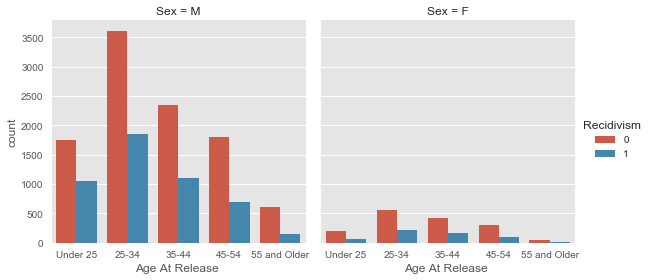

% Recidivism by Sex X Age of Release


Sex  Age At Release 
F    25-34              28.0%
     35-44              29.0%
     45-54              23.0%
     55 and Older       14.0%
     Under 25           25.0%
M    25-34              34.0%
     35-44              32.0%
     45-54              28.0%
     55 and Older       19.0%
     Under 25           38.0%
Name: Recidivism, dtype: object

In [270]:
print "Females are at higher risk of Recidivism between 25-44 vs. Male population with highest risk at under 25"
sns.factorplot(
    col= 'Sex',
    x='Age At Release ',
    hue = 'Recidivism',
    order=('Under 25','25-34','35-44','45-54','55 and Older'),
    data=df,
    kind='count',
)

plt.show()


print '% Recidivism by Sex X Age of Release'

dfy =pd.to_numeric(df_rec_y.groupby(['Sex','Age At Release '])['Recidivism'].count(),errors='coerce')
dfn = df.groupby(['Sex','Age At Release '])['Recidivism'].count()

np.round(100*dfy/dfn).astype(str) + "%"




Recidivism by Offense type X Race


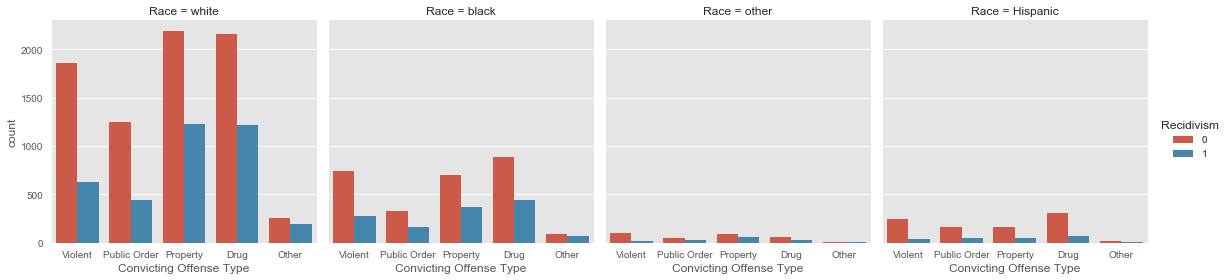

% Recidivism by Sex X Age of Release


Race      Convicting Offense Type
Hispanic  Drug                       18.0%
          Other                      32.0%
          Property                   24.0%
          Public Order               23.0%
          Violent                    14.0%
black     Drug                       33.0%
          Other                      44.0%
          Property                   34.0%
          Public Order               33.0%
          Violent                    27.0%
other     Drug                       32.0%
          Other                      62.0%
          Property                   42.0%
          Public Order               37.0%
          Violent                    19.0%
white     Drug                       36.0%
          Other                      43.0%
          Property                   36.0%
          Public Order               26.0%
          Violent                    25.0%
Name: Recidivism, dtype: object

In [21]:
print "Recidivism by Offense type X Race"

sns.factorplot(
    col= 'Race',
    x='Convicting Offense Type',
    hue = 'Recidivism',
    data=df,
    kind='count',
)

plt.show()

print '% Recidivism by Sex X Age of Release'

dfy2 =pd.to_numeric(df_rec_y.groupby(['Race','Convicting Offense Type'])['Recidivism'].count(),errors='coerce')
dfn2 = df.groupby(['Race','Convicting Offense Type'])['Recidivism'].count()

np.round(100*dfy2/dfn2).astype(str) + "%"


Recidivism by Offense type X Age


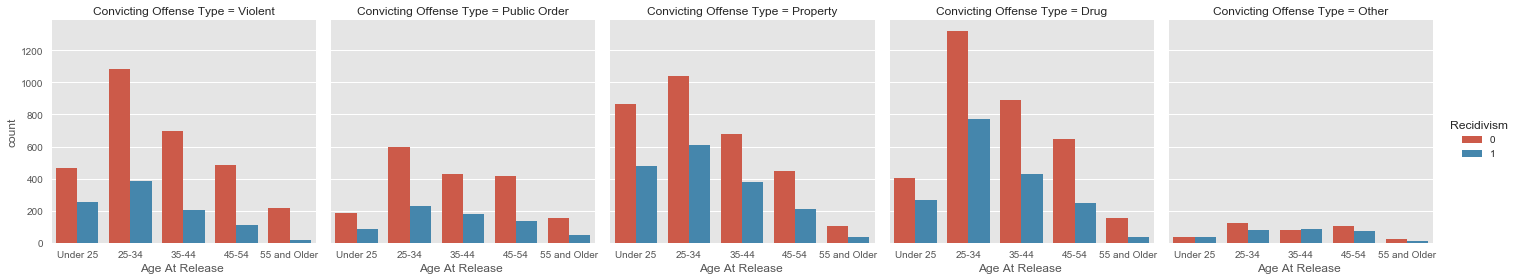

In [22]:
print "Recidivism by Offense type X Age"

sns.factorplot(
    col= 'Convicting Offense Type',
    x = 'Age At Release ',
    hue = 'Recidivism',
    order=('Under 25','25-34','35-44','45-54','55 and Older'),
    data=df,
    kind='count',
)

plt.show()



In [23]:
df.groupby(['Release Type']).agg({'Recidivism':[np.size]})

,Recidivism
,size
Release Type,
Discharged - Expiration of Sentence,1215
Discharged – End of Sentence,5039
Interstate Compact Parole,1
Parole,6986
Parole Granted,2883
Paroled to Detainer - INS,81
Paroled to Detainer - Iowa,41
Paroled to Detainer - Out of State,56


In [93]:
# Group Release Type
def classify_release_type(x):
    if x == 'Discharged - Expiration of Sentence' or x=='Discharged – End of Sentence':
        return 'Discharged'
    elif x == 'Special Sentence' or x=='Released to Special Sentence' :
        return 'Special Sentence'
    else:
        return 'Paroled'



In [94]:
df['Release Type2'] = df['Release Type'].map(classify_release_type)
df_rec_y['Release Type2'] = df_rec_y['Release Type'].map(classify_release_type)
df_rec_n['Release Type2'] = df_rec_n['Release Type'].map(classify_release_type)

/Users/matanefron/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/matanefron/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [26]:
df.groupby(['Release Type2']).agg({'Recidivism':[np.size]})

,Recidivism
,size
Release Type2,
Discharged,6254
Paroled,10287
Special Sentence,519


Axes(0.125,0.125;0.775x0.755)
% Recidivism by release type
Release Type2
Discharged          25.0%
Paroled             35.0%
Special Sentence    53.0%
Name: Recidivism, dtype: object


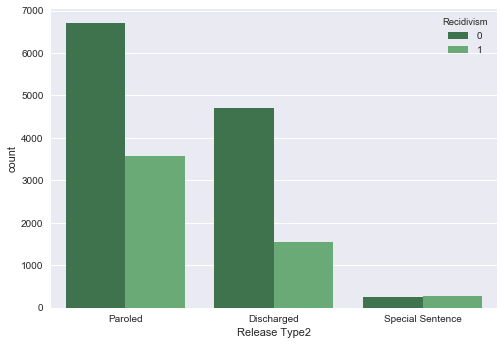

In [27]:
# Recidivism by Release Type 
sns.set(font_scale=1)  
fig, ax = plt.subplots()

print sns.countplot(x="Release Type2",hue="Recidivism", data=df, palette="Greens_d");

print "% Recidivism by release type" 
print np.round(100*(pd.to_numeric(df_rec_y.groupby('Release Type2')['Recidivism'].count(),errors='coerce')
                    /df.groupby('Release Type2')['Recidivism'].count())).astype(str) + "%"


Recidivism by Offense type X Race


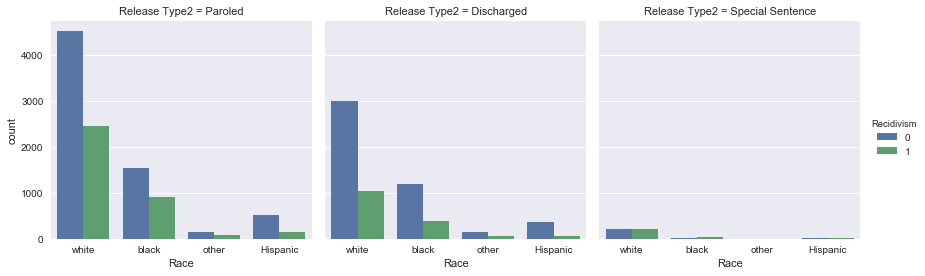

In [28]:
print "Recidivism by Offense type X Race"

sns.factorplot(
    col= 'Release Type2',
    x='Race',
    hue = 'Recidivism',
     data=df,
    kind='count',
)

plt.show()



In [29]:
cols_to_transform = df[['Race','Age At Release ','Sex','Release Type2','Convicting Offense Type',
                        'Convicting Offense Subtype','Convicting Offense Classification','Main Supervising District']]

In [30]:
cols_to_transform.head()

,Race,Age At Release,Sex,Release Type2,Convicting Offense Type,Convicting Offense Subtype,Convicting Offense Classification,Main Supervising District
0,white,Under 25,M,Paroled,Violent,Assault,D Felony,4JD
1,white,55 and Older,M,Paroled,Public Order,OWI,D Felony,7JD
2,white,25-34,M,Paroled,Property,Burglary,D Felony,5JD
3,white,55 and Older,M,Paroled,Drug,Trafficking,C Felony,8JD
4,black,25-34,M,Paroled,Drug,Trafficking,D Felony,3JD


In [31]:
y = df['Recidivism'].values

In [32]:
X = pd.get_dummies(cols_to_transform)
X.head()

,Race_Hispanic,Race_black,Race_other,Race_white,Age At Release _25-34,Age At Release _35-44,Age At Release _45-54,Age At Release _55 and Older,Age At Release _Under 25,Sex_F,...,Main Supervising District_1JD,Main Supervising District_2JD,Main Supervising District_3JD,Main Supervising District_4JD,Main Supervising District_5JD,Main Supervising District_6JD,Main Supervising District_7JD,Main Supervising District_8JD,Main Supervising District_ISC,Main Supervising District_Interstate Compact
0,0,0,0,1,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,1,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [35]:
from sklearn.cross_validation import train_test_split

trainX, testX, trainY, testY = train_test_split(X, y, train_size = .25)
print trainX.shape, testX.shape
print trainY.shape, testY.shape

(4265, 69) (12795, 69)
(4265,) (12795,)


# random forest model

In [165]:
##Need to add Gridserach
from time import time
from scipy.stats import randint as sp_randint

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(n_estimators = 20)

In [166]:
# No optimization
model_rf.fit(trainX,trainY)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [167]:
y_predict = model_rf.predict(testX)

In [168]:
from sklearn.metrics import confusion_matrix, classification_report

cnf_mtx = confusion_matrix(testY, y_predict)
print cnf_mtx

print classification_report(testY, y_predict)

[[7055 1710]
 [2827 1203]]
             precision    recall  f1-score   support

          0       0.71      0.80      0.76      8765
          1       0.41      0.30      0.35      4030

avg / total       0.62      0.65      0.63     12795



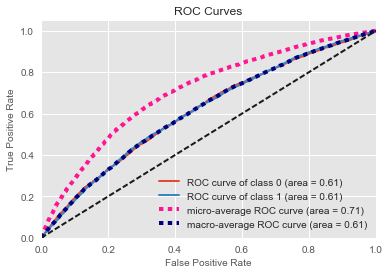

In [182]:
%matplotlib inline

# This is all that's needed for scikit-plot
import matplotlib.pyplot as plt
from scikitplot import classifier_factory

classifier_factory(model_rf)

model_rf.plot_roc_curve(X.as_matrix(), y, random_state=2)
plt.show()

In [242]:
features = X.columns
feature_importances = model_rf.feature_importances_

features_df = pd.DataFrame({'Features': features, 'Importance Score': feature_importances})
features_df.sort_values(by='Importance Score', inplace=True, ascending=False)

features_df.head(10)

,Features,Importance Score
4,Age At Release _25-34,0.052455
3,Race_white,0.045675
5,Age At Release _35-44,0.044150
49,Convicting Offense Classification_D Felony,0.041816
1,Race_black,0.039407
48,Convicting Offense Classification_C Felony,0.037508
8,Age At Release _Under 25,0.036266
6,Age At Release _45-54,0.036195
63,Main Supervising District_5JD,0.033250
46,Convicting Offense Classification_Aggravated M...,0.029103


### Improving Model with Gridsearch

In [170]:
def report(results, n_top=10):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


In [174]:
param_grid = {"max_depth": [10, None],
              "min_samples_split": [2, 5, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "warm_start": [True, False],
              "criterion": ["gini", "entropy"]}


gs = GridSearchCV(model_rf, param_grid=param_grid)
start = time()
gs.fit(trainX,trainY)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(gs.cv_results_['params'])))
report(gs.cv_results_)

GridSearchCV took 78.45 seconds for 144 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.684 (std: 0.002)
Parameters: {'warm_start': False, 'bootstrap': True, 'min_samples_leaf': 10, 'criterion': 'gini', 'min_samples_split': 2, 'max_depth': None}

Model with rank: 2
Mean validation score: 0.683 (std: 0.001)
Parameters: {'warm_start': False, 'bootstrap': True, 'min_samples_leaf': 10, 'criterion': 'entropy', 'min_samples_split': 10, 'max_depth': None}

Model with rank: 3
Mean validation score: 0.681 (std: 0.006)
Parameters: {'warm_start': True, 'bootstrap': False, 'min_samples_leaf': 10, 'criterion': 'entropy', 'min_samples_split': 10, 'max_depth': None}

Model with rank: 4
Mean validation score: 0.681 (std: 0.014)
Parameters: {'warm_start': False, 'bootstrap': True, 'min_samples_leaf': 3, 'criterion': 'entropy', 'min_samples_split': 10, 'max_depth': None}

Model with rank: 5
Mean validation score: 0.680 (std: 0.004)
Parameters: {'warm_start': True, 'bootstrap': 

In [176]:
gs.best_estimator_.fit(trainX,trainY)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=10,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [188]:
y_predict_gs =gs.best_estimator_.predict(testX)

In [189]:
#Confusion matrix

from sklearn.metrics import confusion_matrix, classification_report

cnf_mtx = confusion_matrix(testY, y_predict_gs)
print cnf_mtx

print classification_report(testY, y_predict_gs)

[[8582  183]
 [3779  251]]
             precision    recall  f1-score   support

          0       0.69      0.98      0.81      8765
          1       0.58      0.06      0.11      4030

avg / total       0.66      0.69      0.59     12795



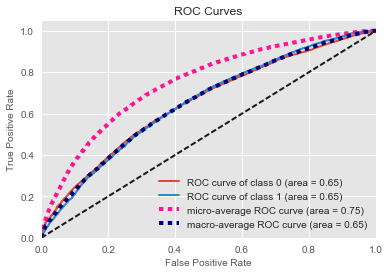

In [190]:
%matplotlib inline

# This is all that's needed for scikit-plot
import matplotlib.pyplot as plt
from scikitplot import classifier_factory

classifier_factory(gs.best_estimator_)

gs.best_estimator_.plot_roc_curve(X.as_matrix(), y, random_state=2)
plt.show()

In [243]:
features = X.columns
feature_importances = gs.best_estimator_.feature_importances_

features_df = pd.DataFrame({'Features': features, 'Importance Score': feature_importances})
features_df.sort_values(by='Importance Score', inplace=True, ascending=False)

features_df.head(10)

,Features,Importance Score
11,Release Type2_Discharged,0.059389
63,Main Supervising District_5JD,0.053875
8,Age At Release _Under 25,0.049747
18,Convicting Offense Type_Violent,0.048802
1,Race_black,0.041065
0,Race_Hispanic,0.038896
13,Release Type2_Special Sentence,0.036570
4,Age At Release _25-34,0.034898
12,Release Type2_Paroled,0.032760
10,Sex_M,0.030599


# Gradient Boosting

In [199]:
from sklearn.ensemble import GradientBoostingClassifier

model_gb = GradientBoostingClassifier(n_estimators = 20)

In [58]:
model_gb.fit(trainX,trainY)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

In [249]:
param_grid = {"loss":['deviance', 'exponential'],
              "max_depth": [3, None],
              "min_samples_split": [2, 5, 10],
              "min_samples_leaf": [1, 3, 10],
              "warm_start": [True, False]}


gs_gb = GridSearchCV(model_gb, param_grid=param_grid)
start = time()
gs_gb.fit(trainX,trainY)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(gs_gb.cv_results_['params'])))
report(gs_gb.cv_results_)

GridSearchCV took 206.89 seconds for 72 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.681 (std: 0.002)
Parameters: {'min_samples_split': 2, 'loss': 'deviance', 'warm_start': True, 'max_depth': 3, 'min_samples_leaf': 3}

Model with rank: 1
Mean validation score: 0.681 (std: 0.002)
Parameters: {'min_samples_split': 2, 'loss': 'deviance', 'warm_start': False, 'max_depth': 3, 'min_samples_leaf': 3}

Model with rank: 1
Mean validation score: 0.681 (std: 0.002)
Parameters: {'min_samples_split': 5, 'loss': 'deviance', 'warm_start': True, 'max_depth': 3, 'min_samples_leaf': 3}

Model with rank: 1
Mean validation score: 0.681 (std: 0.002)
Parameters: {'min_samples_split': 5, 'loss': 'deviance', 'warm_start': False, 'max_depth': 3, 'min_samples_leaf': 3}

Model with rank: 5
Mean validation score: 0.680 (std: 0.002)
Parameters: {'min_samples_split': 10, 'loss': 'deviance', 'warm_start': True, 'max_depth': 3, 'min_samples_leaf': 3}

Model with rank: 5
Mean validation sc

In [210]:
y_predict_gb = gs_gb.best_estimator_.predict(testX)

In [248]:
from sklearn.metrics import confusion_matrix, classification_report

cnf_mtx = confusion_matrix(testY, y_predict_gb)
print cnf_mtx

print classification_report(testY, y_predict_gb)

[[8745   20]
 [3980   50]]
             precision    recall  f1-score   support

          0       0.69      1.00      0.81      8765
          1       0.71      0.01      0.02      4030

avg / total       0.70      0.69      0.57     12795



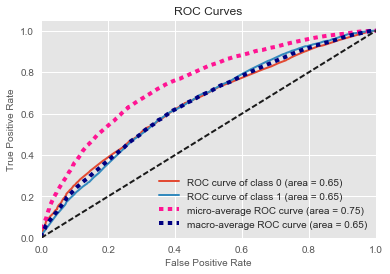

In [245]:
%matplotlib inline

# This is all that's needed for scikit-plot
import matplotlib.pyplot as plt
from scikitplot import classifier_factory

classifier_factory(gs_gb.best_estimator_)

gs_gb.best_estimator_.plot_roc_curve(X.as_matrix(), y, random_state=2)
plt.show()

In [247]:
features = X.columns
feature_importances = gs_gb.best_estimator_.feature_importances_

features_df = pd.DataFrame({'Features': features, 'Importance Score': feature_importances})
features_df.sort_values(by='Importance Score', inplace=True, ascending=False)

features_df.head(10)

,Features,Importance Score
11,Release Type2_Discharged,0.127524
7,Age At Release _55 and Older,0.101060
68,Main Supervising District_Interstate Compact,0.071985
67,Main Supervising District_ISC,0.068222
13,Release Type2_Special Sentence,0.060005
8,Age At Release _Under 25,0.059497
63,Main Supervising District_5JD,0.059060
18,Convicting Offense Type_Violent,0.058059
0,Race_Hispanic,0.047739
29,Convicting Offense Subtype_OWI,0.034906
